<a href="https://colab.research.google.com/github/timuriz/ObjectSegmentationMarsWS25/blob/all_in_one_file_ipynb/mars_semantic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATASET PREPARATION

---



In [ ]:
import os, cv2 # os - files, oper. sys., cv2 - image processing
import numpy as np # arrays
import pandas as pd # excel

from google.colab import drive
drive.mount('/content/drive')

"""
# links on folders with dataset

"""

data_folder = '/content/drive/MyDrive/Mashine Learning/Project/AI4Mars_dataset' # link of dataset folder

img_train_folder = '/content/drive/Othercomputers/Ноутбук/train_images'
mask_train_folder = '/content/drive/Othercomputers/Ноутбук/train_labels'

img_valid_folder = '/content/drive/Othercomputers/Ноутбук/valid_images'
mask_valid_folder = '/content/drive/Othercomputers/Ноутбук/valid_masks'

img_test_folder = '/content/drive/Othercomputers/Ноутбук/test_images'
mask_test_folder = '/content/drive/Othercomputers/Ноутбук/test_labels'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""

# get name of classes and their values

"""

class_dataframe = pd.read_csv('/content/drive/MyDrive/University study/Mashine Learning/Project/labels.csv') # pandas dataframe

class_names = class_dataframe['name'].tolist()

class_gray_values = class_dataframe['gray'].values.tolist()


print('Class Names: ', class_names)
print('Class gray values: ', class_gray_values)

Class Names:  ['soil', 'bedrock', 'sand', 'big rock', 'rest']
Class gray values:  [0, 1, 2, 3, 255]


In [ ]:
import os
import numpy as np
import cv2
from torch.utils.data import Dataset

"""

# implementation of the Dataset class

"""

class CreatImageDataset(Dataset):

    def __init__(self, img_folder, mask_folder, transforms):
      self.img_folder = img_folder
      self.mask_folder = mask_folder
      self.transforms = transforms

      self.img_paths = os.listdir(self.img_folder)
      self.img_paths.sort()

      self.mask_paths = os.listdir(self.mask_folder)
      self.mask_paths.sort()


    # return the amount of files
    def __len__(self):
        return len(self.img_paths)

    # form tensors of the input images and masks
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_paths[idx])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # get Numpy arrays

        mask_path = os.path.join(self.mask_folder, self.mask_paths[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # get Numpy arrays

        # apply an augmentation
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        mask = mask.long()

        return img, mask


AUGMENTATION

In [ ]:
"""
# augmentation functions

"""
import albumentations as aug
from albumentations.pytorch import ToTensorV2


def get_train_transforms(image_size=(256, 256)):
    h, w = image_size
    return aug.Compose([     # albumentations transformation pipeline builder
      aug.Resize(height=h, width=w, interpolation=0), # resize the image and the mask, apply nearest-neighbor interpolation
      aug.RandomCrop(height=int(h * 0.9), width=int(w * 0.9), p=0.5), # crop images and mask with probability 50%(0.5) to decide to convert or not
      aug.Resize(height=h, width=w, interpolation=0),
      aug.HorizontalFlip(p=0.5), # flip with probability 50%
      aug.VerticalFlip(p=0.1),
      aug.Affine(rotate=(-15, 15), scale=(0.9, 1.1), translate_percent=(0.0625, 0.0625), border_mode=0, p=0.5),  # Rotate → rotate around the center (-15% to +15%)
                                                                                                          # Scale → zoom in or out, scale factor [0.9, 1.1]
                                                                                                          # shift → new pixels on the left are filled with a value 0 (shift on 6.25% of image size)
                                                                                                          # border_mode=0 - fill outside area with 0 pixels
      aug.RandomRotate90(p=0.25),
      aug.Normalize(mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)),  # image only, uses ImageNet mean/std by default if we have, else 0-1 normalization
      ToTensorV2() # converts NumPy arrays into PyTorch tensors (3, H, W)
    ], additional_targets={}) # no additional masks

def get_valid_transforms(image_size=(256, 256)):
    h, w = image_size
    return aug.Compose([
        aug.Resize(height=h, width=w, interpolation=0),
        aug.Normalize(mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])


# visualization



In [ ]:
"""

visualization function to preview images and masks

"""

import matplotlib.pyplot as plt

def visualize(**images) -> None: # function does not return anything

    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([]) # remove tick marks and numbers from the x- and y-axes
        plt.yticks([]) # remove tick marks and numbers from the x- and y-axes
        plt.title(" ".join(name.split("_")).title()) # formats and sets the title above the image
        plt.imshow(image)
    plt.show()

In [ ]:
"""

the class for unnormolize image for preliminary visualization

"""

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):

        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m) # apply the return function (x = x_norm ​× s + m)

        return tensor


unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
train_transform = get_train_transforms()
train_dataset = CreatImageDataset(img_train_folder, mask_train_folder, train_transform)

test_transform = get_valid_transforms()
test_dataset = CreatImageDataset(img_test_folder, mask_test_folder, test_transform)

valid_transform = get_valid_transforms()
valid_dataset = CreatImageDataset(img_valid_folder, mask_valid_folder, valid_transform)

In [ ]:
"""

call visualization

"""

idx = np.random.randint(len(train_dataset))
image, mask = train_dataset[idx]
visualize(image=unnorm(image).permute(1, 2, 0), mask=mask)

DATALOADER

In [ ]:
from torch.utils.data import DataLoader

batch_size = 4

n_workers = os.cpu_count()
print("num_workers = ", n_workers) # show how many CPU cores are available

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True, # randomly shuffles the order of samples at the beginning of each epoch.
    num_workers=n_workers,
    drop_last=True, # last smaller batch is discarded
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=n_workers,
    drop_last=False,
)

valid_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=n_workers,
    drop_last=False,
)

num_workers =  2


# MODEL

---



In [ ]:
!pip install segmentation-models-pytorch

In [ ]:

import torch
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnet101",        # ResNet-101 backbone
    encoder_weights="imagenet",      # ImageNet pretrained
    in_channels=3,                   # how many channels the input image has
    classes=5                        # amount of classes
)

images, masks = next(iter(train_dataloader)) # iterator and next batch
outputs = model(images) # deeplab return dictionary "out" and "aux"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.8 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

# TRAINING

---



## Early stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float("inf") # set largest posible number
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        # print("score: ", score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):

        if self.verbose:
            print(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ..."
            )
        torch.save(model.state_dict(), "checkpoint.pth")
        self.val_loss_min = val_loss

In [ ]:
!pip install torchmetrics

## Meter

In [ ]:
"""

# Function for mesuring average metrics

"""

class AvMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
train_loss_meter = AvMeter()
dice_meter = AvMeter()
mIoU_meter = AvMeter()

In [ ]:
miou_meter_evaluate = AvMeter()
dice_meter_evaluate = AvMeter()
acc_meter_evaluate = AvMeter()
loss_meter_evaluate = AvMeter()

## Plot graphs

In [ ]:
import matplotlib.pyplot as plt

"""

# Plot metrics

"""

def plot_metrics(
    train_loss,
    val_loss,
    train_mean_iou=None,
    val_mean_iou=None,
    train_dice_score=None,
    val_dice_score=None
    ):

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(15, 10))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Train Loss')
    plt.plot(epochs, val_loss, 'b', label='Valid Loss')
    plt.title('Train and Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Mean IoU
    if train_mean_iou and val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Traing Mean IoU')
        plt.plot(epochs, val_mean_iou, 'b', label='Valid Mean IoU')
        plt.title('Train and Valid Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()

    # Plot Dice Score
    if train_dice_score and val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Train Dice Score')
        plt.plot(epochs, val_dice_score, 'b', label='Valid Dice Score')
        plt.title('Train and Valid Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()

    plt.tight_layout()
    plt.show()

## Train functions

In [ ]:
def evaluate(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device,
    num_classes,
    loss_fn: torch.nn.Module,
    miou_metric,
    dice_metric,
    acc_metric,
):
    miou_meter_evaluate.reset()
    dice_meter_evaluate.reset()
    acc_meter_evaluate.reset()
    loss_meter_evaluate.reset()

    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            X = X.float().to(device)
            y = y.long().to(device)  # [B, W, H]

            y_pred = model(X)  # [B, 4, H, W]

            print("calculation Loss_fn: ", loss_fn(y_pred, y).item())

            loss_meter_evaluate.update(loss_fn(y_pred, y).item())
            print("loss_meter:", loss_meter_evaluate.val)
            print("loss_meter:", loss_meter_evaluate.sum)

            # Apply argmax to y_pred before passing to metrics
            y_pred_labels = y_pred.argmax(dim=1)

            print("calculation miou: ", miou_metric(y_pred_labels, y).item())
            miou_meter_evaluate.update(miou_metric(y_pred_labels, y).item())
            print("miou_meter:", miou_meter_evaluate.val)
            print("miou_meter:", miou_meter_evaluate.sum)
            # y_for_dice = y.clone()
            # y_for_dice[y_for_dice == 255] = 0
            # dice_val = dice_metric(y_pred_labels, y_for_dice).item()
            dice_val = dice_metric(y_pred_labels, y).item()
            dice_meter_evaluate.update(dice_val)
            acc_meter_evaluate.update(acc_metric(y_pred_labels, y).item())

    loss = loss_meter_evaluate.avg
    print("loss_in_evaluate", loss)
    miou = miou_meter_evaluate.avg
    print("miou_in_evaluate", miou)
    dice = dice_meter_evaluate.avg
    acc = acc_meter_evaluate.avg

    return loss, acc, miou, dice

In [ ]:
from tqdm.notebook import tqdm
from torch.amp import autocast
from torch.amp import GradScaler


# create scaler
scaler = GradScaler()

def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    miou_metric,
    dice_metric,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    device: torch.device,
):
    model.cuda()
    model.train()

    train_loss_meter.reset()
    dice_meter.reset()
    mIoU_meter.reset()

    train_progress = tqdm(dataloader, colour="green")

    for batch, (X, y) in enumerate(train_progress):
        print("batch:", batch)

        X = X.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.long)

        # Clear old gradients
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda"):
            y_pred = model(X)            # [B, C, H, W]
            loss = loss_fn(y_pred, y)

        print("calculation loss_train:", loss.item())

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            train_loss_meter.update(loss.item())

            y_pred_labels = y_pred.argmax(dim=1)  # [B, H, W]

            # y_for_dice = y.clone()
            # y_for_dice[y_for_dice == 255] = 0
            # dice_val = dice_metric(y_pred_labels, y_for_dice).item()

            dice_val = dice_metric(y_pred_labels, y).item()
            dice_meter.update(dice_val)

            mIoU_meter.update(miou_metric(y_pred_labels, y).item())

    scheduler.step()

    print(X.dtype)
    print(next(model.parameters()).dtype)
    return (
        train_loss_meter.avg,
        mIoU_meter.avg,
        dice_meter.avg,
    )


In [ ]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    valid_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    miou_metric,
    dice_metric,
    acc_metric,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    device: torch.device,
) -> None :

    early_stopping = EarlyStopping(patience=5, verbose=True)


    train_loss_list = []
    valid_loss_list = []
    train_miou_list = []
    valid_miou_list = []
    train_dice_list = []
    valid_dice_list = []


    for epoch in range(epochs): # first epoch is 0th
        train_loss, train_miou, train_dice = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            scheduler=scheduler,
            miou_metric=miou_metric,
            dice_metric=dice_metric,
            device=device,
        )

        valid_loss, valid_accuracy, valid_miou, valid_dice = evaluate(
            model=model,
            dataloader=valid_dataloader,
            device=device,
            num_classes=4,
            loss_fn=loss_fn,
            miou_metric=miou_metric,
            dice_metric=dice_metric,
            acc_metric=acc_metric,
        )
        #scheduler.step(valid_loss)

        # print("valid_miou:", valid_miou)
        # print("valid_loss:", valid_loss)

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_miou_list.append(train_miou)
        valid_miou_list.append(valid_miou)
        train_dice_list.append(train_dice)
        valid_dice_list.append(valid_dice)

        print(
            f"TRAIN | Epoch: {epoch + 1}/{epochs} | Loss: {train_loss:.4f}, mIoU: {train_miou:.4f}, Dice: {train_dice:.4f}"
        )


        early_stopping(1 - valid_miou, model) # mIoU measures segmentation quality directly

        if early_stopping.early_stop:
            print("Early stopping")
            break


        print(
            f"VAL | Loss : {valid_loss:4f} | Accuracy: {valid_accuracy:.4f} | mIoU: {valid_miou:.4f} | Dice Score: {valid_dice:.4f}"
        )

    plot_metrics(train_loss_list, valid_loss_list, train_miou_list, valid_miou_list, train_dice_list, valid_dice_list)



## Hyperparameters



In [ ]:
import torch
import torch.nn as nn

from torchmetrics.classification import MulticlassJaccardIndex, MulticlassAccuracy
from torchmetrics.segmentation import DiceScore



"""
model - DeepLabV3+, Resnet-101 (backbone)

"""

epochs = 25

num_classes = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = nn.CrossEntropyLoss(ignore_index=255)

miou_metric = MulticlassJaccardIndex(num_classes=num_classes, average="macro", ignore_index=255).to(device) #  # intersection/Union, average="macro" - compute the metric separately for each class, then take the simple average across classes.

dice_metric = DiceScore(num_classes=num_classes, average="macro").to(device) #


acc_metric = MulticlassAccuracy(num_classes=num_classes, average="macro", ignore_index=255).to(device) # Accuracy = correct pixels / total pixels

# optimizer = torch.optim.AdamW(
#                                 model.parameters(),
#                                 lr=5e-5, # Learning rate = 0.0001
#                                 weight_decay=1e-4 # Penalizes large weights, Regularization strength
#     )

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# scheduler = torch.optim.lr_scheduler.PolynomialLR(
#                                 optimizer,
#                                 total_iters=epochs,
#                                 power=1.0
#     )
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.5,
#     patience=2,
#     verbose=True
# )

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)



early_stopping = EarlyStopping(patience=5, verbose=True)

## Train

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch version:", torch.__version__)


CUDA available: True
CUDA version: 11.8
PyTorch version: 2.5.1


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA works")
else:
    device = torch.device("cpu")
    print("CPU works")


CUDA works


cuda works


  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 1.407029390335083
batch: 1
calculation loss_train: 1.3907368183135986
batch: 2
calculation loss_train: 1.5726637840270996
batch: 3
calculation loss_train: 1.4889277219772339
batch: 4
calculation loss_train: 1.4375983476638794
batch: 5
calculation loss_train: 1.3987563848495483
batch: 6
calculation loss_train: 1.4821374416351318
batch: 7
calculation loss_train: 1.4428774118423462
batch: 8
calculation loss_train: 1.4629149436950684
batch: 9
calculation loss_train: 1.4850819110870361
batch: 10
calculation loss_train: 1.444161057472229
batch: 11
calculation loss_train: 1.5264167785644531
batch: 12
calculation loss_train: 1.5160443782806396
batch: 13
calculation loss_train: 1.4045902490615845
batch: 14
calculation loss_train: 1.2956286668777466
batch: 15
calculation loss_train: 1.452541708946228
batch: 16
calculation loss_train: 1.4194252490997314
batch: 17
calculation loss_train: 1.4217268228530884
batch: 18
calculation loss_train: 1.4296541213989258
batch:

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 1.2904903888702393
batch: 1
calculation loss_train: 1.386878490447998
batch: 2
calculation loss_train: 1.478129267692566
batch: 3
calculation loss_train: 1.3861091136932373
batch: 4
calculation loss_train: 1.3509190082550049
batch: 5
calculation loss_train: 1.273738145828247
batch: 6
calculation loss_train: 1.3928254842758179
batch: 7
calculation loss_train: 1.330217719078064
batch: 8
calculation loss_train: 1.236457109451294
batch: 9
calculation loss_train: 1.345720648765564
batch: 10
calculation loss_train: 1.2314523458480835
batch: 11
calculation loss_train: 1.366908073425293
batch: 12
calculation loss_train: 1.2419525384902954
batch: 13
calculation loss_train: 1.4058319330215454
batch: 14
calculation loss_train: 1.284954309463501
batch: 15
calculation loss_train: 1.3196033239364624
batch: 16
calculation loss_train: 1.2628722190856934
batch: 17
calculation loss_train: 1.24481201171875
batch: 18
calculation loss_train: 1.2482322454452515
batch: 19
cal

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 1.3686085939407349
batch: 1
calculation loss_train: 1.3154174089431763
batch: 2
calculation loss_train: 1.2090471982955933
batch: 3
calculation loss_train: 1.3494852781295776
batch: 4
calculation loss_train: 1.2671211957931519
batch: 5
calculation loss_train: 1.3896108865737915
batch: 6
calculation loss_train: 1.2268919944763184
batch: 7
calculation loss_train: 1.150474190711975
batch: 8
calculation loss_train: 1.3045248985290527
batch: 9
calculation loss_train: 1.2798457145690918
batch: 10
calculation loss_train: 1.2569860219955444
batch: 11
calculation loss_train: 1.2665984630584717
batch: 12
calculation loss_train: 1.1956034898757935
batch: 13
calculation loss_train: 1.249404788017273
batch: 14
calculation loss_train: 1.229317545890808
batch: 15
calculation loss_train: 1.2368897199630737
batch: 16
calculation loss_train: 1.1863309144973755
batch: 17
calculation loss_train: 1.2839539051055908
batch: 18
calculation loss_train: 1.2999637126922607
batch:

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 1.2196786403656006
batch: 1
calculation loss_train: 1.1485413312911987
batch: 2
calculation loss_train: 1.2447385787963867
batch: 3
calculation loss_train: 1.2964842319488525
batch: 4
calculation loss_train: 1.1297165155410767
batch: 5
calculation loss_train: 1.175715684890747
batch: 6
calculation loss_train: 1.3402678966522217
batch: 7
calculation loss_train: 1.2209141254425049
batch: 8
calculation loss_train: 1.1836950778961182
batch: 9
calculation loss_train: 1.090248942375183
batch: 10
calculation loss_train: 1.2078301906585693
batch: 11
calculation loss_train: 1.2096152305603027
batch: 12
calculation loss_train: 1.2132222652435303
batch: 13
calculation loss_train: 1.4079487323760986
batch: 14
calculation loss_train: 1.3301892280578613
batch: 15
calculation loss_train: 1.164608120918274
batch: 16
calculation loss_train: 1.2471076250076294
batch: 17
calculation loss_train: 1.1576932668685913
batch: 18
calculation loss_train: 1.1700844764709473
batch:

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 1.1730709075927734
batch: 1
calculation loss_train: 1.1722702980041504
batch: 2
calculation loss_train: 1.270713448524475
batch: 3
calculation loss_train: 1.1618571281433105
batch: 4
calculation loss_train: 1.080395221710205
batch: 5
calculation loss_train: 1.0428210496902466
batch: 6
calculation loss_train: 1.2087805271148682
batch: 7
calculation loss_train: 1.1793748140335083
batch: 8
calculation loss_train: 1.1883350610733032
batch: 9
calculation loss_train: 1.0196266174316406
batch: 10
calculation loss_train: 1.2579257488250732
batch: 11
calculation loss_train: 1.064621090888977
batch: 12
calculation loss_train: 1.2113765478134155
batch: 13
calculation loss_train: 1.14036226272583
batch: 14
calculation loss_train: 1.2368042469024658
batch: 15
calculation loss_train: 1.0415143966674805
batch: 16
calculation loss_train: 1.170809268951416
batch: 17
calculation loss_train: 1.1496052742004395
batch: 18
calculation loss_train: 1.284860610961914
batch: 19


  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 1.124619483947754
batch: 1
calculation loss_train: 1.2191219329833984
batch: 2
calculation loss_train: 1.1586601734161377
batch: 3
calculation loss_train: 1.0362049341201782
batch: 4
calculation loss_train: 1.1343709230422974
batch: 5
calculation loss_train: 1.007070541381836
batch: 6
calculation loss_train: 1.1839878559112549
batch: 7
calculation loss_train: 1.017817497253418
batch: 8
calculation loss_train: 1.2781643867492676
batch: 9
calculation loss_train: 1.0687024593353271
batch: 10
calculation loss_train: 1.1086773872375488
batch: 11
calculation loss_train: 1.1481796503067017
batch: 12
calculation loss_train: 1.0472017526626587
batch: 13
calculation loss_train: 1.0574047565460205
batch: 14
calculation loss_train: 1.2388908863067627
batch: 15
calculation loss_train: 1.1442815065383911
batch: 16
calculation loss_train: 1.0693082809448242
batch: 17
calculation loss_train: 1.13228178024292
batch: 18
calculation loss_train: 1.1266508102416992
batch: 1

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 1.059678316116333
batch: 1
calculation loss_train: 1.106621503829956
batch: 2
calculation loss_train: 0.9883742928504944
batch: 3
calculation loss_train: 1.048797607421875
batch: 4
calculation loss_train: 1.0307155847549438
batch: 5
calculation loss_train: 1.1288275718688965
batch: 6
calculation loss_train: 0.9629533290863037
batch: 7
calculation loss_train: 1.0740129947662354
batch: 8
calculation loss_train: 1.0970429182052612
batch: 9
calculation loss_train: 1.0741572380065918
batch: 10
calculation loss_train: 1.0330489873886108
batch: 11
calculation loss_train: 1.0414003133773804
batch: 12
calculation loss_train: 1.060728669166565
batch: 13
calculation loss_train: 0.9391434192657471
batch: 14
calculation loss_train: 1.0235153436660767
batch: 15
calculation loss_train: 1.0400711297988892
batch: 16
calculation loss_train: 1.0791093111038208
batch: 17
calculation loss_train: 0.9694916605949402
batch: 18
calculation loss_train: 0.9842318892478943
batch: 

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.9819624423980713
batch: 1
calculation loss_train: 0.9596405625343323
batch: 2
calculation loss_train: 0.9967408180236816
batch: 3
calculation loss_train: 1.0952773094177246
batch: 4
calculation loss_train: 1.2650810480117798
batch: 5
calculation loss_train: 1.1571588516235352
batch: 6
calculation loss_train: 1.0075035095214844
batch: 7
calculation loss_train: 0.9150693416595459
batch: 8
calculation loss_train: 1.145682454109192
batch: 9
calculation loss_train: 0.9231180548667908
batch: 10
calculation loss_train: 1.0432443618774414
batch: 11
calculation loss_train: 0.9926778674125671
batch: 12
calculation loss_train: 0.8900008797645569
batch: 13
calculation loss_train: 1.095151424407959
batch: 14
calculation loss_train: 0.9595931768417358
batch: 15
calculation loss_train: 1.0116395950317383
batch: 16
calculation loss_train: 0.9724376797676086
batch: 17
calculation loss_train: 0.960649847984314
batch: 18
calculation loss_train: 0.9518350958824158
batch:

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.9499547481536865
batch: 1
calculation loss_train: 1.0091394186019897
batch: 2
calculation loss_train: 0.9965294599533081
batch: 3
calculation loss_train: 0.906978964805603
batch: 4
calculation loss_train: 1.0291378498077393
batch: 5
calculation loss_train: 0.8831949234008789
batch: 6
calculation loss_train: 1.0412522554397583
batch: 7
calculation loss_train: 0.9953001737594604
batch: 8
calculation loss_train: 0.9802873134613037
batch: 9
calculation loss_train: 1.1303129196166992
batch: 10
calculation loss_train: 0.9964674115180969
batch: 11
calculation loss_train: 1.150144100189209
batch: 12
calculation loss_train: 1.052273154258728
batch: 13
calculation loss_train: 0.9328770637512207
batch: 14
calculation loss_train: 0.8738594055175781
batch: 15
calculation loss_train: 0.8960141539573669
batch: 16
calculation loss_train: 1.1436960697174072
batch: 17
calculation loss_train: 0.845241129398346
batch: 18
calculation loss_train: 0.9539263248443604
batch: 

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.8142241835594177
batch: 1
calculation loss_train: 0.9616690874099731
batch: 2
calculation loss_train: 0.9281880855560303
batch: 3
calculation loss_train: 0.9735454320907593
batch: 4
calculation loss_train: 0.8786284923553467
batch: 5
calculation loss_train: 0.985608696937561
batch: 6
calculation loss_train: 0.9621307253837585
batch: 7
calculation loss_train: 0.8774833679199219
batch: 8
calculation loss_train: 0.8774668574333191
batch: 9
calculation loss_train: 1.0470339059829712
batch: 10
calculation loss_train: 0.9161622524261475
batch: 11
calculation loss_train: 1.0378397703170776
batch: 12
calculation loss_train: 1.0049054622650146
batch: 13
calculation loss_train: 1.0197646617889404
batch: 14
calculation loss_train: 0.9300025105476379
batch: 15
calculation loss_train: 0.8660797476768494
batch: 16
calculation loss_train: 0.888664960861206
batch: 17
calculation loss_train: 0.9165175557136536
batch: 18
calculation loss_train: 1.0037977695465088
batch

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.9096752405166626
batch: 1
calculation loss_train: 0.8145425319671631
batch: 2
calculation loss_train: 0.922669529914856
batch: 3
calculation loss_train: 0.8822160363197327
batch: 4
calculation loss_train: 1.003541350364685
batch: 5
calculation loss_train: 0.9369632005691528
batch: 6
calculation loss_train: 0.8480607271194458
batch: 7
calculation loss_train: 0.8688627481460571
batch: 8
calculation loss_train: 0.8387402296066284
batch: 9
calculation loss_train: 0.8977545499801636
batch: 10
calculation loss_train: 0.927268385887146
batch: 11
calculation loss_train: 0.8576902151107788
batch: 12
calculation loss_train: 0.8687601089477539
batch: 13
calculation loss_train: 1.0161312818527222
batch: 14
calculation loss_train: 0.9642676711082458
batch: 15
calculation loss_train: 0.83234703540802
batch: 16
calculation loss_train: 0.9200923442840576
batch: 17
calculation loss_train: 0.8177374601364136
batch: 18
calculation loss_train: 1.0461993217468262
batch: 1

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.866381049156189
batch: 1
calculation loss_train: 0.9026484489440918
batch: 2
calculation loss_train: 0.8533723950386047
batch: 3
calculation loss_train: 0.913020133972168
batch: 4
calculation loss_train: 0.8686878681182861
batch: 5
calculation loss_train: 0.8322435021400452
batch: 6
calculation loss_train: 0.8392565250396729
batch: 7
calculation loss_train: 0.8926351070404053
batch: 8
calculation loss_train: 0.8132658004760742
batch: 9
calculation loss_train: 0.9252810478210449
batch: 10
calculation loss_train: 0.8533496856689453
batch: 11
calculation loss_train: 0.8002890348434448
batch: 12
calculation loss_train: 0.9153444766998291
batch: 13
calculation loss_train: 0.8687636852264404
batch: 14
calculation loss_train: 0.7891632318496704
batch: 15
calculation loss_train: 0.8408157229423523
batch: 16
calculation loss_train: 0.9692081212997437
batch: 17
calculation loss_train: 0.8759195804595947
batch: 18
calculation loss_train: 0.872438907623291
batch:

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.7477626800537109
batch: 1
calculation loss_train: 1.0148688554763794
batch: 2
calculation loss_train: 1.0005474090576172
batch: 3
calculation loss_train: 1.1160064935684204
batch: 4
calculation loss_train: 0.7708193063735962
batch: 5
calculation loss_train: 0.869890570640564
batch: 6
calculation loss_train: 0.8236623406410217
batch: 7
calculation loss_train: 0.780777633190155
batch: 8
calculation loss_train: 0.8145959973335266
batch: 9
calculation loss_train: 0.8276563286781311
batch: 10
calculation loss_train: 0.8122864365577698
batch: 11
calculation loss_train: 0.8519473075866699
batch: 12
calculation loss_train: 0.8352910876274109
batch: 13
calculation loss_train: 0.8587663173675537
batch: 14
calculation loss_train: 0.7859705090522766
batch: 15
calculation loss_train: 0.8523186445236206
batch: 16
calculation loss_train: 0.9023981094360352
batch: 17
calculation loss_train: 0.862909197807312
batch: 18
calculation loss_train: 0.8284528851509094
batch:

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.7283928990364075
batch: 1
calculation loss_train: 0.9433550834655762
batch: 2
calculation loss_train: 0.7878557443618774
batch: 3
calculation loss_train: 0.7977572679519653
batch: 4
calculation loss_train: 0.8405596017837524
batch: 5
calculation loss_train: 0.8395569920539856
batch: 6
calculation loss_train: 0.731448233127594
batch: 7
calculation loss_train: 0.9379035234451294
batch: 8
calculation loss_train: 0.8839302659034729
batch: 9
calculation loss_train: 0.8218087553977966
batch: 10
calculation loss_train: 0.764708399772644
batch: 11
calculation loss_train: 0.8914538025856018
batch: 12
calculation loss_train: 0.8115312457084656
batch: 13
calculation loss_train: 0.961857795715332
batch: 14
calculation loss_train: 0.8439627885818481
batch: 15
calculation loss_train: 1.0251487493515015
batch: 16
calculation loss_train: 0.9145796298980713
batch: 17
calculation loss_train: 0.9273252487182617
batch: 18
calculation loss_train: 0.85205078125
batch: 19
c

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.7347186803817749
batch: 1
calculation loss_train: 0.803989052772522
batch: 2
calculation loss_train: 0.9086668491363525
batch: 3
calculation loss_train: 0.8964723944664001
batch: 4
calculation loss_train: 0.8233658075332642
batch: 5
calculation loss_train: 0.870659589767456
batch: 6
calculation loss_train: 0.8002713918685913
batch: 7
calculation loss_train: 0.9780173897743225
batch: 8
calculation loss_train: 0.8711517453193665
batch: 9
calculation loss_train: 0.7830229997634888
batch: 10
calculation loss_train: 0.8295468688011169
batch: 11
calculation loss_train: 0.852137565612793
batch: 12
calculation loss_train: 0.8410999774932861
batch: 13
calculation loss_train: 0.9178273677825928
batch: 14
calculation loss_train: 0.8437643051147461
batch: 15
calculation loss_train: 0.8163549304008484
batch: 16
calculation loss_train: 0.7216569781303406
batch: 17
calculation loss_train: 0.7990347146987915
batch: 18
calculation loss_train: 0.8516190052032471
batch:

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.8313379287719727
batch: 1
calculation loss_train: 0.7162014245986938
batch: 2
calculation loss_train: 0.9151603579521179
batch: 3
calculation loss_train: 0.8004244565963745
batch: 4
calculation loss_train: 0.8292117118835449
batch: 5
calculation loss_train: 0.9761480093002319
batch: 6
calculation loss_train: 0.7510998249053955
batch: 7
calculation loss_train: 0.808652400970459
batch: 8
calculation loss_train: 0.9317790269851685
batch: 9
calculation loss_train: 1.012266993522644
batch: 10
calculation loss_train: 0.8277559280395508
batch: 11
calculation loss_train: 0.7694387435913086
batch: 12
calculation loss_train: 0.842018187046051
batch: 13
calculation loss_train: 0.8921500444412231
batch: 14
calculation loss_train: 0.6951766014099121
batch: 15
calculation loss_train: 0.9539328813552856
batch: 16
calculation loss_train: 0.9572752714157104
batch: 17
calculation loss_train: 0.8189463019371033
batch: 18
calculation loss_train: 0.7520606517791748
batch:

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.9041992425918579
batch: 1
calculation loss_train: 0.8182295560836792
batch: 2
calculation loss_train: 0.8866162896156311
batch: 3
calculation loss_train: 0.7199143171310425
batch: 4
calculation loss_train: 0.8370413780212402
batch: 5
calculation loss_train: 0.849998950958252
batch: 6
calculation loss_train: 0.7783743143081665
batch: 7
calculation loss_train: 0.8765852451324463
batch: 8
calculation loss_train: 0.7661560773849487
batch: 9
calculation loss_train: 0.7742988467216492
batch: 10
calculation loss_train: 0.8088133335113525
batch: 11
calculation loss_train: 0.7976101636886597
batch: 12
calculation loss_train: 0.9143064022064209
batch: 13
calculation loss_train: 0.839518666267395
batch: 14
calculation loss_train: 0.7324696183204651
batch: 15
calculation loss_train: 0.8095847964286804
batch: 16
calculation loss_train: 0.8171348571777344
batch: 17
calculation loss_train: 0.7871544361114502
batch: 18
calculation loss_train: 0.8016782999038696
batch

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.8464489579200745
batch: 1
calculation loss_train: 0.8134710192680359
batch: 2
calculation loss_train: 0.81025230884552
batch: 3
calculation loss_train: 0.7977886199951172
batch: 4
calculation loss_train: 0.8400078415870667
batch: 5
calculation loss_train: 0.7821285724639893
batch: 6
calculation loss_train: 0.7757949829101562
batch: 7
calculation loss_train: 0.8394437432289124
batch: 8
calculation loss_train: 0.816643476486206
batch: 9
calculation loss_train: 0.820075273513794
batch: 10
calculation loss_train: 0.8100391626358032
batch: 11
calculation loss_train: 0.7764363288879395
batch: 12
calculation loss_train: 0.7469579577445984
batch: 13
calculation loss_train: 0.7263672351837158
batch: 14
calculation loss_train: 0.7773045301437378
batch: 15
calculation loss_train: 0.8920470476150513
batch: 16
calculation loss_train: 0.7447311878204346
batch: 17
calculation loss_train: 0.7646380066871643
batch: 18
calculation loss_train: 0.8189560174942017
batch: 

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.7187188863754272
batch: 1
calculation loss_train: 0.731093168258667
batch: 2
calculation loss_train: 0.765442967414856
batch: 3
calculation loss_train: 0.8212985396385193
batch: 4
calculation loss_train: 0.8295255303382874
batch: 5
calculation loss_train: 0.7703334093093872
batch: 6
calculation loss_train: 0.8882708549499512
batch: 7
calculation loss_train: 0.7907169461250305
batch: 8
calculation loss_train: 0.7998906373977661
batch: 9
calculation loss_train: 0.7506345510482788
batch: 10
calculation loss_train: 0.7503839731216431
batch: 11
calculation loss_train: 0.7202033400535583
batch: 12
calculation loss_train: 0.7354850769042969
batch: 13
calculation loss_train: 0.7447439432144165
batch: 14
calculation loss_train: 0.8030734062194824
batch: 15
calculation loss_train: 0.8187941312789917
batch: 16
calculation loss_train: 0.9237903356552124
batch: 17
calculation loss_train: 1.025917410850525
batch: 18
calculation loss_train: 0.9034040570259094
batch:

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.7627750039100647
batch: 1
calculation loss_train: 0.707365095615387
batch: 2
calculation loss_train: 0.7929413318634033
batch: 3
calculation loss_train: 0.6729016304016113
batch: 4
calculation loss_train: 0.8637222051620483
batch: 5
calculation loss_train: 0.7042591571807861
batch: 6
calculation loss_train: 0.7608087062835693
batch: 7
calculation loss_train: 0.8137156367301941
batch: 8
calculation loss_train: 0.7241190671920776
batch: 9
calculation loss_train: 0.8859701156616211
batch: 10
calculation loss_train: 0.7061147093772888
batch: 11
calculation loss_train: 0.8683275580406189
batch: 12
calculation loss_train: 0.8704999685287476
batch: 13
calculation loss_train: 0.8306741118431091
batch: 14
calculation loss_train: 0.7720583081245422
batch: 15
calculation loss_train: 0.6730848550796509
batch: 16
calculation loss_train: 0.7830920219421387
batch: 17
calculation loss_train: 0.8800790905952454
batch: 18
calculation loss_train: 0.7569679617881775
batc

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.6473249793052673
batch: 1
calculation loss_train: 0.8573525547981262
batch: 2
calculation loss_train: 0.9915209412574768
batch: 3
calculation loss_train: 0.9578056335449219
batch: 4
calculation loss_train: 0.777061939239502
batch: 5
calculation loss_train: 0.791445255279541
batch: 6
calculation loss_train: 0.7725065350532532
batch: 7
calculation loss_train: 0.8416540622711182
batch: 8
calculation loss_train: 0.8331023454666138
batch: 9
calculation loss_train: 0.7770764231681824
batch: 10
calculation loss_train: 0.9188750982284546
batch: 11
calculation loss_train: 0.8260191679000854
batch: 12
calculation loss_train: 0.8458837866783142
batch: 13
calculation loss_train: 0.8289240598678589
batch: 14
calculation loss_train: 0.7516052722930908
batch: 15
calculation loss_train: 0.750800371170044
batch: 16
calculation loss_train: 0.8410770893096924
batch: 17
calculation loss_train: 0.8118166923522949
batch: 18
calculation loss_train: 0.7752406597137451
batch:

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.7341798543930054
batch: 1
calculation loss_train: 0.721172571182251
batch: 2
calculation loss_train: 0.6930868625640869
batch: 3
calculation loss_train: 0.7959867715835571
batch: 4
calculation loss_train: 0.7844973802566528
batch: 5
calculation loss_train: 0.7274123430252075
batch: 6
calculation loss_train: 0.7545685768127441
batch: 7
calculation loss_train: 0.7545006275177002
batch: 8
calculation loss_train: 0.7149432897567749
batch: 9
calculation loss_train: 0.7233474254608154
batch: 10
calculation loss_train: 0.783115565776825
batch: 11
calculation loss_train: 0.7603492140769958
batch: 12
calculation loss_train: 0.7150918841362
batch: 13
calculation loss_train: 0.6975138783454895
batch: 14
calculation loss_train: 1.0492331981658936
batch: 15
calculation loss_train: 0.8071147799491882
batch: 16
calculation loss_train: 0.6384561061859131
batch: 17
calculation loss_train: 0.9127622842788696
batch: 18
calculation loss_train: 0.7820646166801453
batch: 1

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.6710108518600464
batch: 1
calculation loss_train: 0.7010221481323242
batch: 2
calculation loss_train: 0.7824752926826477
batch: 3
calculation loss_train: 0.6958986520767212
batch: 4
calculation loss_train: 0.7954513430595398
batch: 5
calculation loss_train: 0.8907528519630432
batch: 6
calculation loss_train: 0.7355514168739319
batch: 7
calculation loss_train: 0.8136497735977173
batch: 8
calculation loss_train: 0.6072766780853271
batch: 9
calculation loss_train: 0.8555841445922852
batch: 10
calculation loss_train: 0.6675122976303101
batch: 11
calculation loss_train: 0.759077787399292
batch: 12
calculation loss_train: 0.789249062538147
batch: 13
calculation loss_train: 0.7446842789649963
batch: 14
calculation loss_train: 0.8279788494110107
batch: 15
calculation loss_train: 0.9174448847770691
batch: 16
calculation loss_train: 0.7890178561210632
batch: 17
calculation loss_train: 0.6397465467453003
batch: 18
calculation loss_train: 0.8489090204238892
batch

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.7741641402244568
batch: 1
calculation loss_train: 0.7030408978462219
batch: 2
calculation loss_train: 0.886570394039154
batch: 3
calculation loss_train: 0.8617033958435059
batch: 4
calculation loss_train: 0.7179524898529053
batch: 5
calculation loss_train: 0.7079363465309143
batch: 6
calculation loss_train: 0.7520481944084167
batch: 7
calculation loss_train: 0.8269779086112976
batch: 8
calculation loss_train: 0.9126750230789185
batch: 9
calculation loss_train: 0.7844330072402954
batch: 10
calculation loss_train: 0.7241449356079102
batch: 11
calculation loss_train: 0.730070173740387
batch: 12
calculation loss_train: 0.7798700928688049
batch: 13
calculation loss_train: 0.7407587170600891
batch: 14
calculation loss_train: 0.6762630939483643
batch: 15
calculation loss_train: 0.855810821056366
batch: 16
calculation loss_train: 0.8335392475128174
batch: 17
calculation loss_train: 0.7554548978805542
batch: 18
calculation loss_train: 0.7062593102455139
batch:

  0%|          | 0/84 [00:00<?, ?it/s]

batch: 0
calculation loss_train: 0.7279632091522217
batch: 1
calculation loss_train: 0.6715811491012573
batch: 2
calculation loss_train: 0.7298845052719116
batch: 3
calculation loss_train: 0.7479667663574219
batch: 4
calculation loss_train: 0.844062328338623
batch: 5
calculation loss_train: 0.7209633588790894
batch: 6
calculation loss_train: 0.815555214881897
batch: 7
calculation loss_train: 0.7161785960197449
batch: 8
calculation loss_train: 0.9751408696174622
batch: 9
calculation loss_train: 0.7757408618927002
batch: 10
calculation loss_train: 0.7971750497817993
batch: 11
calculation loss_train: 0.9340673089027405
batch: 12
calculation loss_train: 0.8131173253059387
batch: 13
calculation loss_train: 0.6590942144393921
batch: 14
calculation loss_train: 0.8737931251525879
batch: 15
calculation loss_train: 0.871132493019104
batch: 16
calculation loss_train: 0.8118969798088074
batch: 17
calculation loss_train: 0.7270314693450928
batch: 18
calculation loss_train: 0.7826098799705505
batch:

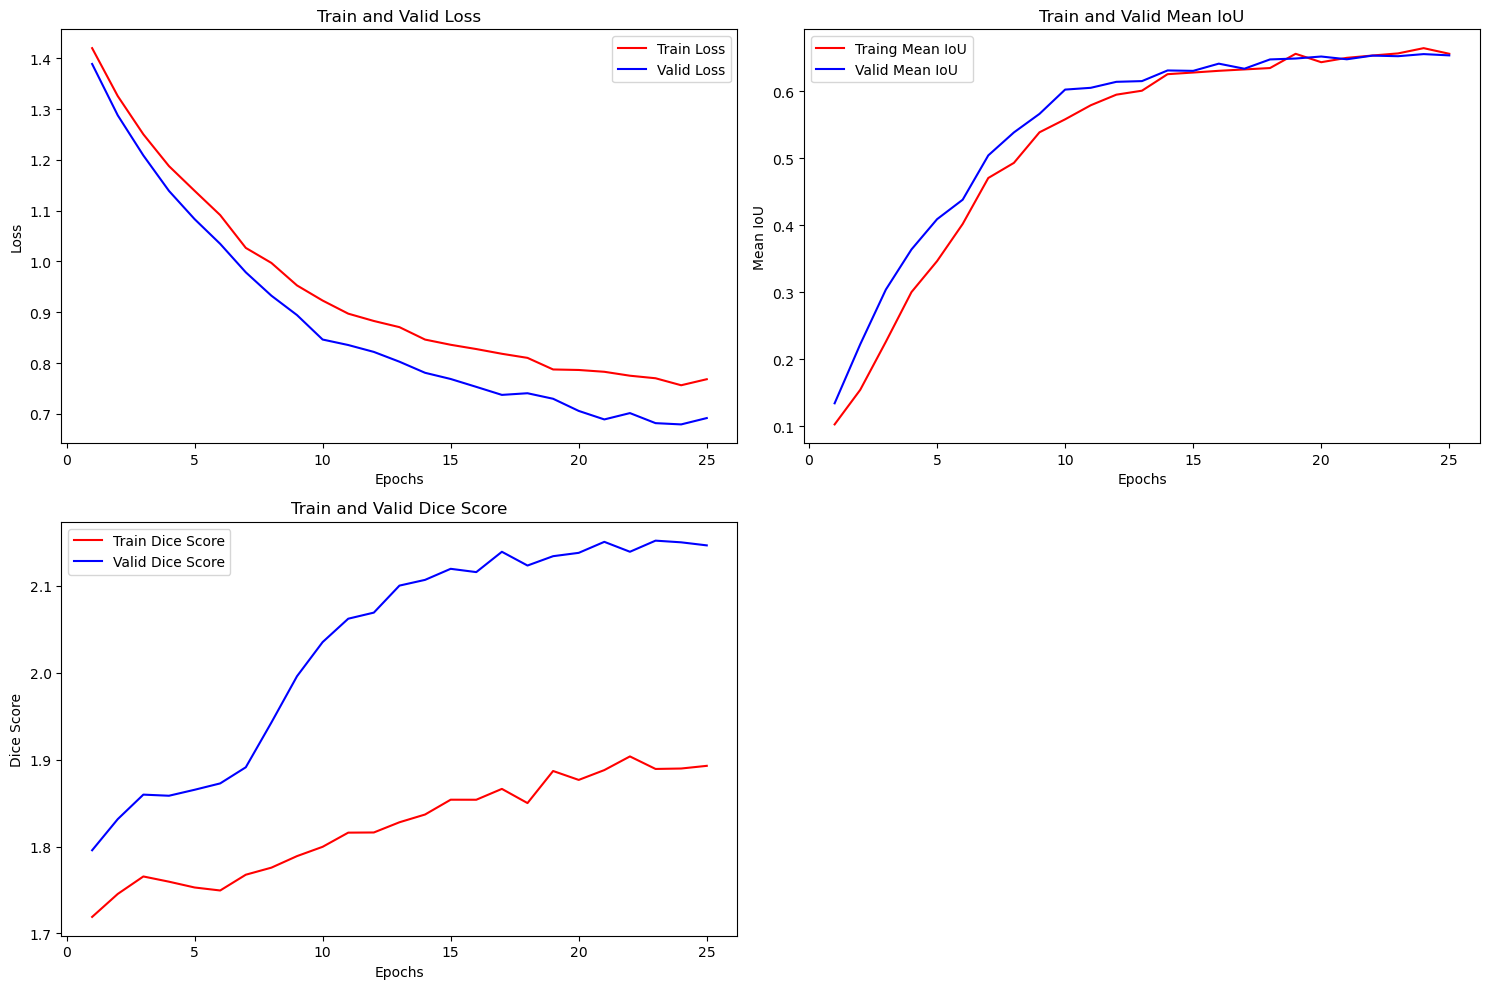

In [ ]:
if device.type == "cuda":
    with torch.amp.autocast("cuda"):
        print("cuda works")
        train(
            model,
            train_dataloader,
            valid_dataloader,
            optimizer,
            loss_fn,
            epochs,
            miou_metric,
            dice_metric,
            acc_metric,
            scheduler,
            device,
        )
else:
    print("cpu works")
    train(
        model,
        train_dataloader,
        valid_dataloader,
        optimizer,
        loss_fn,
        epochs,
        miou_metric,
        dice_metric,
        acc_metric,
        scheduler,
        device,
    )

# EVALUATION

---



## Show prediction masks

In [ ]:
import torch
import segmentation_models_pytorch as smp

In [ ]:
# model_pth = "C://Kotik//Project_Mars//checkpoints//checkpoint_13epochs_08.01.pth"
model_pth = "C://Kotik//Project_Mars//checkpoint.pth"
model = smp.DeepLabV3Plus(
    encoder_name="resnet101",        # ResNet-101 backbone
    encoder_weights="imagenet",      # ImageNet pretrained
    in_channels=3,                   # how many channels the input image has
    classes=4                        # amount of classes
)


checkpoint = torch.load(model_pth, weights_only=True)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
# COLORMAP = [
#     [0, 0, 0],       # Class 0 → black - soil
#     [0, 0, 180],     # class 1 → blue - bedrock
#     [0, 180, 0],     # class 2 → green - sand
#     [180, 0, 0]     # class 3 → red - big rock
# ]

In [ ]:
COLORMAP = {
    0:   (0, 0, 0),       # soil black
    1:   (255, 0, 0),     # bedrock red
    2:   (0, 255, 0),     # sand green
    3:   (0, 0, 255),     # big rock blue
    255: (255, 255, 255) # NULL / ignore
}

In [ ]:
def show_prediction(
    model,
    device,
    test_dataset,
    num_imgs=5,
):
    model.to(device)
    model.eval()

    ids = np.random.choice(len(test_dataset), num_imgs, replace=False)
    print("Indices:", ids)

    fig, axes = plt.subplots(3, num_imgs, figsize=(4*num_imgs, 10))

    if num_imgs == 1:
        axes = axes.reshape(3, 1)

    with torch.no_grad():
        for col, idx in enumerate(ids):
            orig_img, mask = test_dataset[idx]

            img = orig_img.to(device).float().unsqueeze(0)
            logits = model(img)              # [1, C, H, W]
            print("logits", logits)
            print("min, max:", logits.min(), logits.max())

            preds = logits.argmax(dim=1)[0]  # [H, W]
            print("pred_after_argmax", preds)

            image_np = unnorm(orig_img).permute(1, 2, 0).cpu().numpy()
            mask_np = mask.cpu().numpy()
            preds_np = preds.cpu().numpy()


            gt_color = np.zeros((*mask_np.shape, 3), dtype=np.uint8)
            pred_color = np.zeros((*preds_np.shape, 3), dtype=np.uint8)

            for label, color in COLORMAP.items():
                gt_color[mask_np == label] = color
                pred_color[preds_np == label] = color

            axes[0, col].imshow(image_np)
            axes[0, col].set_title("Image")
            axes[0, col].axis("off")

            axes[1, col].imshow(gt_color)
            axes[1, col].set_title("GT Mask")
            axes[1, col].axis("off")

            axes[2, col].imshow(pred_color)
            axes[2, col].set_title("Pred Mask")
            axes[2, col].axis("off")

    plt.tight_layout()
    plt.show()


Indices: [97 59 25 10 26]
logits tensor([[[[ 2.3325e+14,  2.4062e+14,  2.4800e+14,  ...,  1.3937e+14,
            1.0564e+14,  7.1909e+13],
          [ 2.6352e+14,  2.7429e+14,  2.8506e+14,  ...,  1.7083e+14,
            1.3218e+14,  9.3534e+13],
          [ 2.9379e+14,  3.0796e+14,  3.2212e+14,  ...,  2.0229e+14,
            1.5872e+14,  1.1516e+14],
          ...,
          [ 1.9252e+14,  1.9571e+14,  1.9891e+14,  ...,  1.5823e+14,
            1.2225e+14,  8.6275e+13],
          [ 1.6826e+14,  1.6987e+14,  1.7149e+14,  ...,  1.3174e+14,
            1.0048e+14,  6.9219e+13],
          [ 1.4400e+14,  1.4404e+14,  1.4407e+14,  ...,  1.0524e+14,
            7.8701e+13,  5.2163e+13]],

         [[-6.9861e+14, -7.9908e+14, -8.9956e+14,  ..., -9.6909e+14,
           -9.0837e+14, -8.4765e+14],
          [-7.9123e+14, -9.0894e+14, -1.0266e+15,  ..., -1.1036e+15,
           -1.0328e+15, -9.6207e+14],
          [-8.8386e+14, -1.0188e+15, -1.1537e+15,  ..., -1.2381e+15,
           -1.1573e+15, -

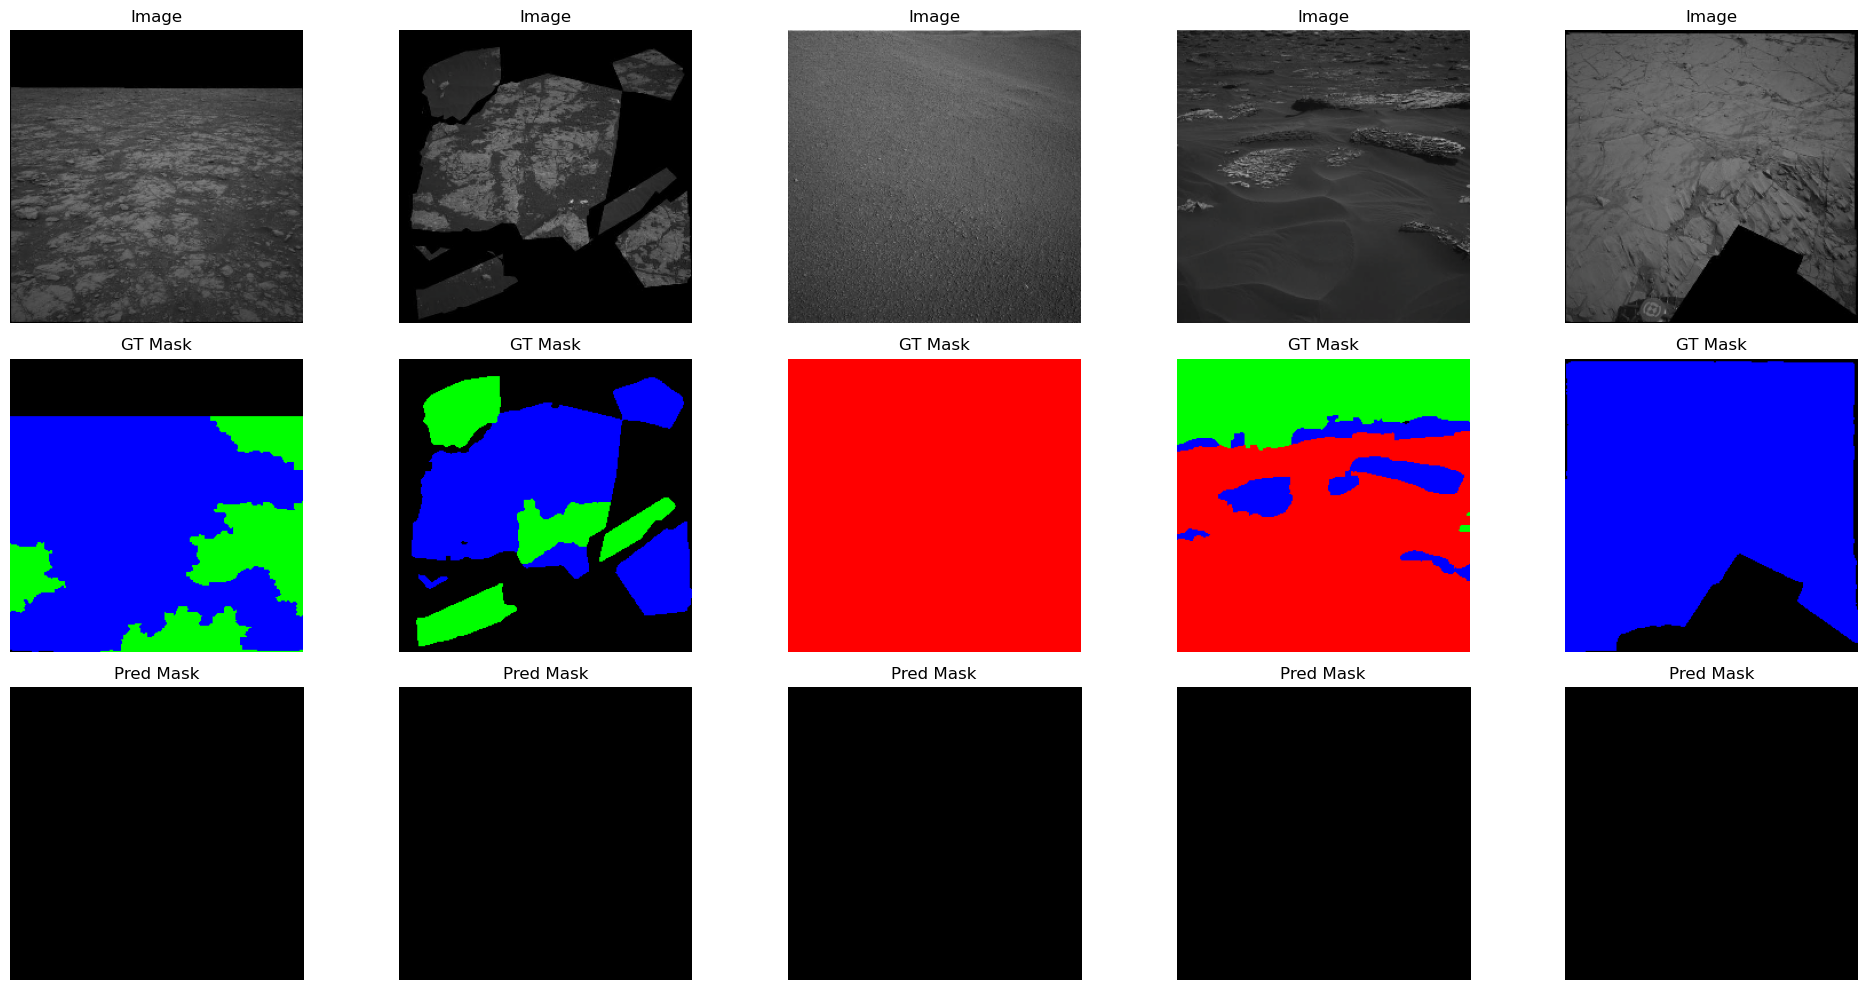

In [ ]:
show_prediction(
    model,
    device,
    test_dataset,
    #num_classes=4,
    num_imgs=5
)

# DEPLOYMENT

---

